In [1]:
import tensorflow as tf
import random 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

print (tf.__version__)

2.8.0


In [2]:
# import FASHION MNIST
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_img, train_lbl), (tst_img, tst_lbl) = fashion_mnist.load_data()

In [3]:
class_names = ['T-shirt', 'trouser', 'hoodie', 'dress', 'coat', 
               'sandal', 'shirt', 'sneaker', 'bag', 'hightop shoes']

In [4]:
# 60k training imgs in the training set with each img represented as 28x28pix
train_img.shape

(60000, 28, 28)

In [5]:
# 60k training lbls
len(train_lbl)

60000

In [6]:
train_lbl

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [7]:
tst_img.shape 

(10000, 28, 28)

In [8]:
len(tst_lbl)

10000

# Preprocess the Data 

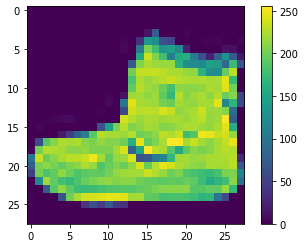

In [9]:
# the pix value goes form 0 to 255
plt.figure()
plt.imshow(train_img[0])
plt.colorbar()
plt.grid(False)
# plt.xlabel(class_names[train_lbl[0]])
plt.show()


In [10]:
# scaling values to range of 0 to 1. 
train_img = train_img / 255.0
tst_img = tst_img / 255.0

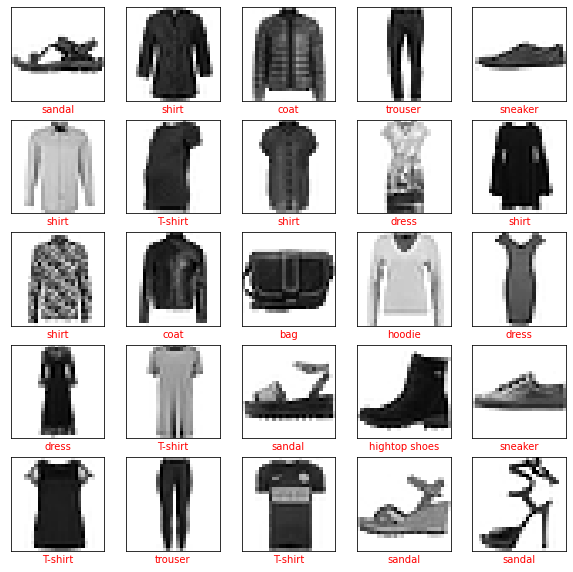

In [11]:
plt.figure(figsize = (10,10))
for i in range(25):
    ax = plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    a = random.randrange(60000)
    plt.imshow(train_img[a], cmap = plt.cm.binary)
    plt.xlabel(class_names[train_lbl[a]])
    ax.xaxis.label.set_color('red')
plt.show()

# Build Model
### layer setup

In [12]:
# 3 layers network model
model = tf.keras.Sequential([
    # first layer for flattening
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    # 1 hidden layer with 128 nodes
    tf.keras.layers.Dense(128, activation = 'relu'),
    # 1 output layer
    tf.keras.layers.Dense(10)
    
])
# tf.summary.histogram("Model Histogram", model)

### model compiling

In [13]:
model.compile(
    # how the model is updated based on the data it sees and its loss function
    optimizer = 'adam',
    # measures how accurate the model is in the training
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True),
    # monitors the training and testing step. 
    # uses accuracy, the fration of the img that are correctly classified
    metrics = ['accuracy']
    
)


In [14]:
model.fit(train_img, train_lbl, epochs = 10)

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4942 - accuracy: 0.8260
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3727 - accuracy: 0.8651
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3358 - accuracy: 0.8775
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.3108 - accuracy: 0.8849
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2925 - accuracy: 0.8916
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2784 - accuracy: 0.8971
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2666 - accuracy: 0.9015
Epoch 8/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2552 - accuracy: 0.9058
Epoch 9/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2477 - accuracy: 0.9082
Epoch 10/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.235

### accuracy evaluation

In [15]:
tst_loss, tst_acc = model.evaluate(tst_img, tst_lbl, verbose = 2)
print('\nTest Acc: ', tst_acc)

313/313 - 0s - loss: 0.3358 - accuracy: 0.8832 - 371ms/epoch - 1ms/step

Test Acc:  0.8831999897956848


In [16]:
#function for plotting the image and the prediction
def plt_img(i, pred_arr, tru_lbl, img):
    tru_lbl, img = tru_lbl[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap = plt.cm.binary)
    
    pred_lbl= np.argmax(pred_arr)
    if pred_lbl == tru_lbl: 
        color = 'green'
    else:
        color = 'red'
    
    plt.xlabel(
        "{} {:2.0f}% ({})".format(
            class_names[pred_lbl],
            100*np.max(pred_arr),
            class_names[tru_lbl]),
        color = color
    )


def plt_val_arr(i, pred_arr, tru_lbl):
    tru_lbl = tru_lbl[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplt = plt.bar(range(10),pred_arr, color = "#777777")
    plt.ylim([0,1])
    pred_lbl = np.argmax(pred_arr)
    
    thisplt[pred_lbl].set_color('red')
    thisplt[tru_lbl].set_color('green')       

# Adversarial Img Gen

In [17]:
prob_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax()
])

In [18]:
# model doesnt take tst_img[0], so expanded the dimensions
pred = prob_model.predict(tf.expand_dims(tst_img[0], axis = 0))

In [19]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True)

def create_adversarial_pattern(input_image, input_label):
    input_image = tf.convert_to_tensor(input_image, np.float32)
  
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = prob_model(tf.expand_dims(input_image, axis = 0))
        loss = loss_object(input_label, prediction)

    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, input_image)
    # Get the sign of the gradients to create the perturbation
    signed_grad = tf.sign(gradient)
    return signed_grad, input_label

### Making new training set with adversarial example

In [20]:
# Making new index with size of original set
new_index = train_img.shape[0]

# making the new training set with double the size of original set
new_train_image = np.zeros(shape = ((new_index* 2), 28, 28))
new_train_image[:new_index] = train_img

new_train_label = np.zeros(shape = (new_index *2))
new_train_label[:new_index] = train_lbl

# adding the original set with the adversarial example to the new training set
for i, tr_im in enumerate(train_img):
    new_train_image[new_index + i], new_train_label[new_index + i] =  create_adversarial_pattern(train_img[i], train_lbl[i])

Text(0.5, 1.0, 'shirt')

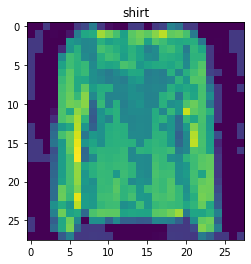

In [21]:
#checking the dataset
item = 9999
plt.imshow(train_img[item] + 0.1 * new_train_image[item+new_index])
plt.title(class_names[np.int32(new_train_label[item])])


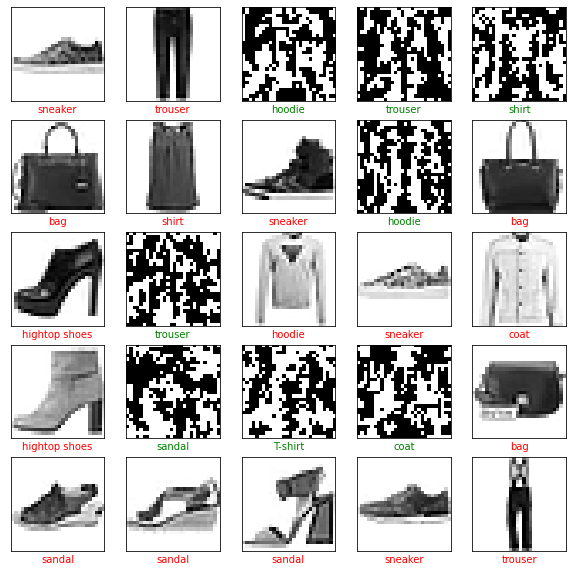

In [22]:
plt.figure(figsize = (10,10))
for i in range(25):
    ax = plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    a = random.randrange(60000*2)
    plt.imshow(new_train_image[a], cmap = plt.cm.binary)
    plt.xlabel(class_names[np.int32(new_train_label[a])])
    if a > 60000:
        ax.xaxis.label.set_color('green')
    else: 
        ax.xaxis.label.set_color('red')
plt.show()

In [23]:
for i, image in enumerate(train_img):
    adv_x = image + (0.1* new_train_image[i+new_index])
    new_train_image[new_index + i] = tf.clip_by_value(adv_x, -1, 1)

Text(0.5, 1.0, 'T-shirt')

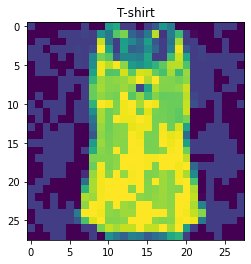

In [24]:
item = 9997
plt.imshow(new_train_image[item+new_index])
plt.title(class_names[np.int32(new_train_label[item + new_index])])

### New task:

make sure which condition the network is safe   
    define which adversarial input intervl is safe for certain nodes
given attacker knows only few nodes
    test if its safe
add advex to training to imporve the model, change the parameters

# Training New Neural Network With Adversarial Example

In [25]:
model2 = tf.keras.Sequential([
    # first layer for flattening
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    # 1 hidden layer with 128 nodes
    tf.keras.layers.Dense(128, activation = 'relu'),
    # 1 output layer
    tf.keras.layers.Dense(10)
    
])

model2.compile(
    # how the model is updated based on the data it sees and its loss function
    optimizer = 'adam',
    # measures how accurate the model is in the training
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True),
    # monitors the training and testing step. 
    # uses accuracy, the fration of the img that are correctly classified
    metrics = ['accuracy']
    
)

In [26]:
model2.fit(new_train_image, new_train_label, epochs = 10)

Epoch 1/10
3750/3750 [==============================] - 5s 1ms/step - loss: 0.3214 - accuracy: 0.8903
Epoch 2/10
3750/3750 [==============================] - 4s 1ms/step - loss: 0.2258 - accuracy: 0.9196
Epoch 3/10
3750/3750 [==============================] - 4s 1ms/step - loss: 0.1957 - accuracy: 0.9295
Epoch 4/10
3750/3750 [==============================] - 4s 1ms/step - loss: 0.1779 - accuracy: 0.9356
Epoch 5/10
3750/3750 [==============================] - 4s 1ms/step - loss: 0.1674 - accuracy: 0.9390
Epoch 6/10
3750/3750 [==============================] - 4s 1ms/step - loss: 0.1573 - accuracy: 0.9426
Epoch 7/10
3750/3750 [==============================] - 4s 1ms/step - loss: 0.1492 - accuracy: 0.9445
Epoch 8/10
3750/3750 [==============================] - 4s 1ms/step - loss: 0.1428 - accuracy: 0.9467
Epoch 9/10
3750/3750 [==============================] - 5s 1ms/step - loss: 0.1354 - accuracy: 0.9494
Epoch 10/10
3750/3750 [==============================] - 4s 1ms/step - loss: 0.129

In [27]:
tst_loss, tst_acc = model2.evaluate(tst_img, tst_lbl, verbose = 2)
print('\nTest Acc: ', tst_acc)

313/313 - 0s - loss: 0.3518 - accuracy: 0.8792 - 328ms/epoch - 1ms/step

Test Acc:  0.8791999816894531


In [28]:
prob_model2 = tf.keras.Sequential([
    model2,
    tf.keras.layers.Softmax()
])

## Checking the model accuracy with adversairial example

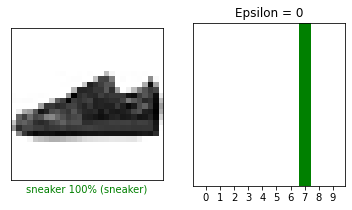

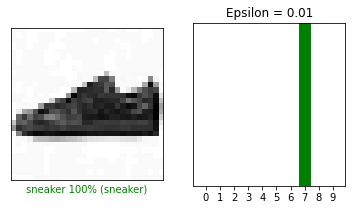

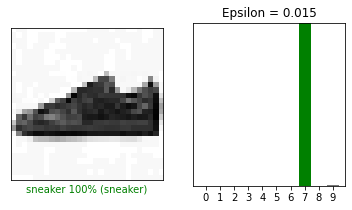

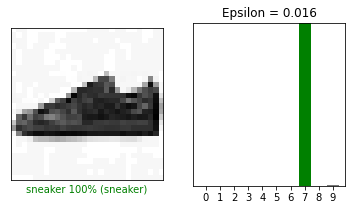

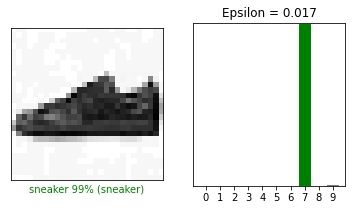

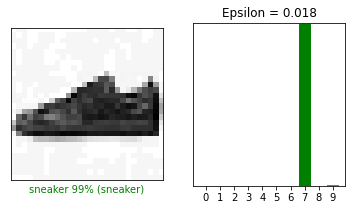

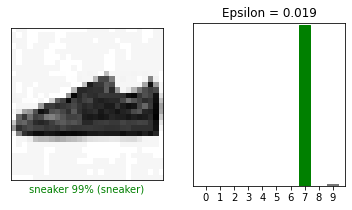

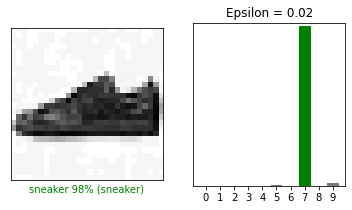

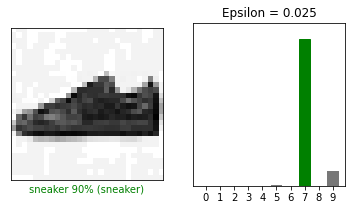

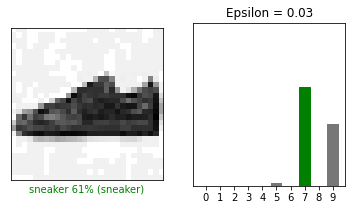

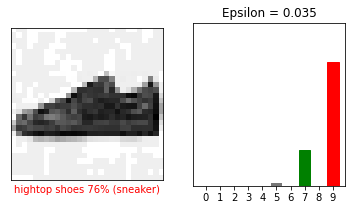

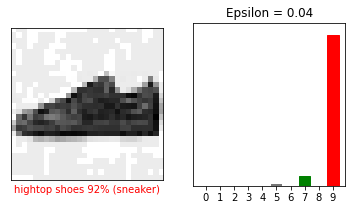

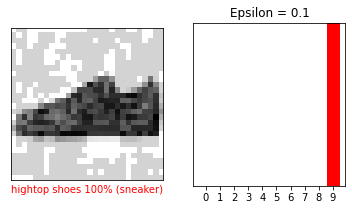

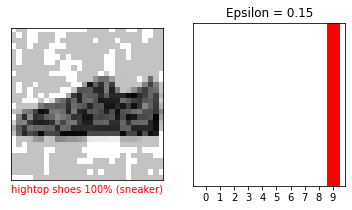

In [45]:
epsilons = [0, 0.01, 0.015, 0.016, 0.017, 0.018, 0.019, 0.02, 0.025, 0.03, 0.035, 0.04, 0.1, 0.15]

# Get the input label of the image.
item = 22
perturbations, grbge = create_adversarial_pattern(tst_img[item], tst_lbl[item])

# plt.imshow(perturbations/225)
for i, eps in enumerate(epsilons):
    adv_x = tst_img[item] + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    predictions = prob_model(tf.expand_dims(adv_x, axis=0))
    plt.figure(figsize = (6,3))
    plt.subplot(1,2,1)
    plt_img(item, predictions[0], tst_lbl, tst_img + eps*perturbations)
    plt.subplot(1,2,2)
    plt_val_arr(item, predictions[0], tst_lbl)
    plt.show
    plt.title(f'Epsilon = {eps}')

## Checking the model accuracy with adversairial example

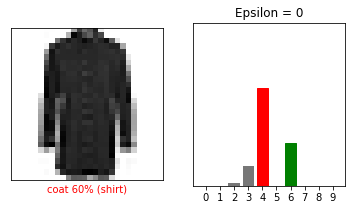

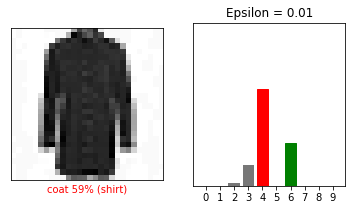

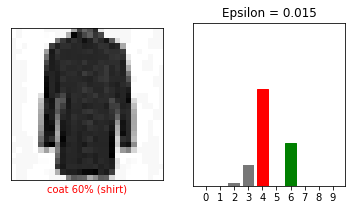

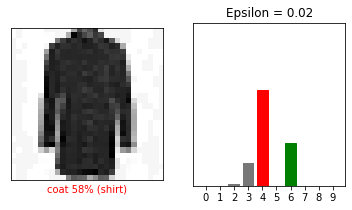

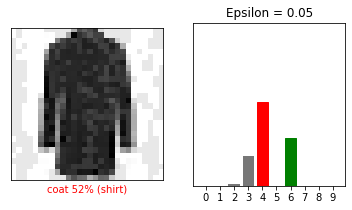

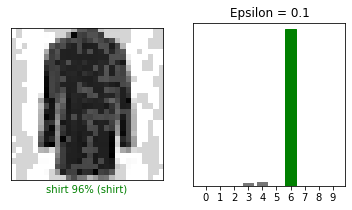

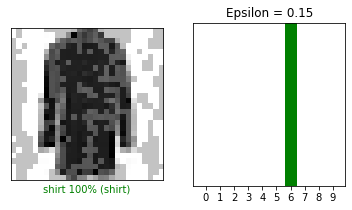

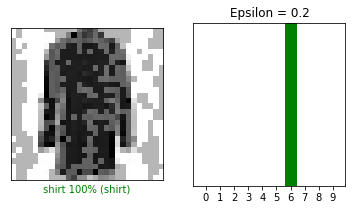

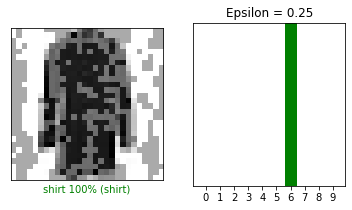

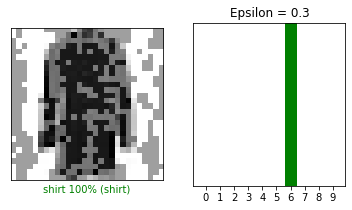

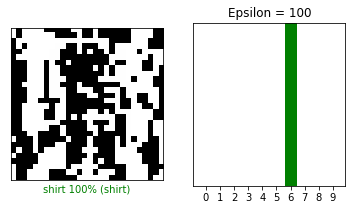

In [30]:
epsilons = [0, 0.01, 0.015, 0.02, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 100 ]

# Get the input label of the image.
item = 444
perturbations, grbge = create_adversarial_pattern(tst_img[item], tst_lbl[item])

# plt.imshow(perturbations/225)
for i, eps in enumerate(epsilons):
    adv_x = tst_img[item] + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    predictions = prob_model2(tf.expand_dims(adv_x, axis=0))
    plt.figure(figsize = (6,3))
    plt.subplot(1,2,1)
    plt_img(item, predictions[0], tst_lbl, tst_img + eps*perturbations)
    plt.subplot(1,2,2)
    plt_val_arr(item, predictions[0], tst_lbl)
    plt.show
    plt.title(f'Epsilon = {eps}')

## Test on different objects

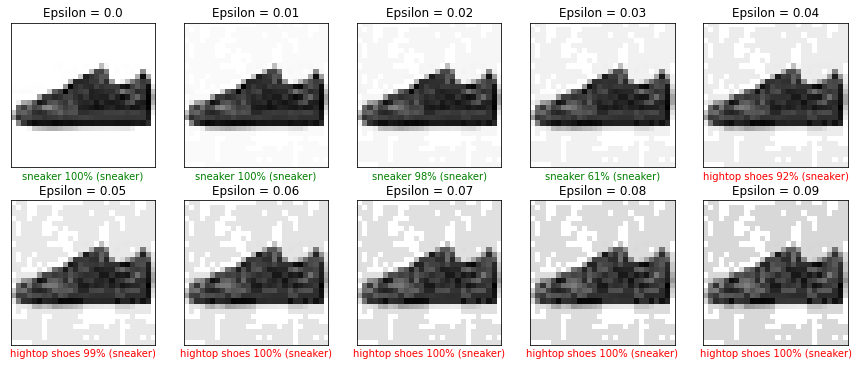

In [79]:
# Get the input label of the image.
item = 22
perturbations, grbge = create_adversarial_pattern(tst_img[item], tst_lbl[item])


# plt.imshow(perturbations/225)
plt.figure(figsize =(15, 6))
eps = 0
for i in range(10):
    ax = plt.subplot(2,5,i+1)
    adv_x = tst_img[item] + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    predictions = prob_model(tf.expand_dims(adv_x, axis=0))    
    # plt.figure(figsize = (6,3))
    # plt.subplot(1,2,1)
    plt_img(item, predictions[0], tst_lbl, tst_img + eps*perturbations)
    # plt.subplot(1,2,2)
    # plt_val_arr(item, predictions[0], tst_lbl)
    plt.show
    plt.title(f'Epsilon = {0.01*i}')
    eps += 0.01

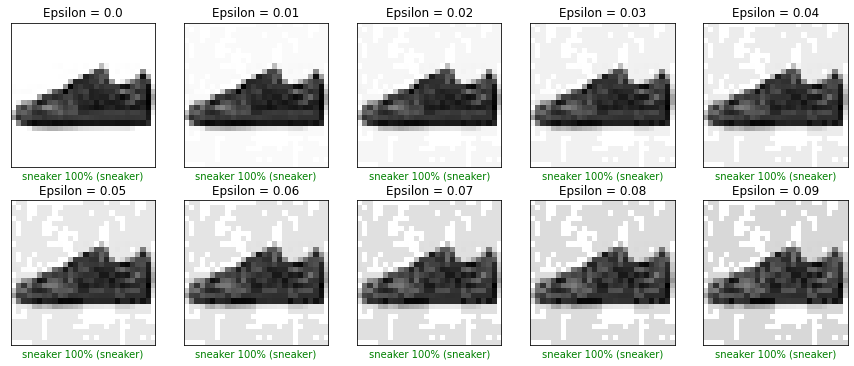

In [77]:
# Get the input label of the image.
item = 22
perturbations, grbge = create_adversarial_pattern(tst_img[item], tst_lbl[item])


# plt.imshow(perturbations/225)
plt.figure(figsize =(15, 6))
eps = 0
for i in range(10):
    ax = plt.subplot(2,5,i+1)
    adv_x = tst_img[item] + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    predictions = prob_model2(tf.expand_dims(adv_x, axis=0))    
    # plt.figure(figsize = (6,3))
    # plt.subplot(1,2,1)
    plt_img(item, predictions[0], tst_lbl, tst_img + eps*perturbations)
    # plt.subplot(1,2,2)
    # plt_val_arr(item, predictions[0], tst_lbl)
    plt.show
    plt.title(f'Epsilon = {0.01*i}')
    eps += 0.01